<a href="https://colab.research.google.com/github/SGN-047/YOLOclassifier/blob/main/TACO_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "sgn047"
os.environ['KAGGLE_KEY'] = "88b3c22c02c7fef646587b82962773cc"
!kaggle datasets download -d kneroma/tacotrashdataset
!kaggle datasets download -d rkuo2000/yolov5-taco-models

100% 2.79G/2.79G [00:43<00:00, 27.6MB/s]
100% 2.79G/2.79G [00:43<00:00, 68.9MB/s]
100% 51.7M/51.7M [00:01<00:00, 37.2MB/s]



In [ ]:
!unzip -o "/content/tacotrashdataset.zip" -d "/content"
!unzip -o "/content/yolov5-taco-models.zip" -d "/content"

In [ ]:
!mkdir TACOdata
!mkdir yolov5-taco-models

In [ ]:
!git clone https://github.com/rkuo2000/yolov5
%cd yolov5
!pwd

In [ ]:
!pip install pycocotools

In [ ]:
from utils.google_utils import *
attempt_download('weights/yolov5s.pt')
attempt_download('weights/yolov5m.pt')
attempt_download('weights/yolov5l.pt')
attempt_download('weights/yolov5x.pt')

In [ ]:
#Preparing dataset

In [ ]:
import os
import shutil
import numpy as np
import tqdm

In [ ]:
from pycocotools.coco import COCO
data_source = COCO(annotation_file='/content/TACOdata/data/annotations.json')

In [ ]:
label_transfer = {5: 0, 12: 1, 29:3, 59:7}

In [ ]:
img_ids = data_source.getImgIds()

catIds = data_source.getCatIds()
categories = data_source.loadCats(catIds)
categories.sort(key=lambda x: x['id'])
classes = {}
coco_labels = {}
coco_labels_inverse = {}
for c in categories:
    coco_labels[len(classes)] = c['id']
    coco_labels_inverse[c['id']] = len(classes)
    classes[c['name']] = len(classes)

class_num = {}

In [ ]:
!mkdir -p tmp/labels tmp/images
save_base_path  = 'tmp/labels/'
save_image_path = 'tmp/images/'

In [ ]:
for index, img_id in tqdm.tqdm(enumerate(img_ids), desc='change .json file to .txt file'):
    img_info = data_source.loadImgs(img_id)[0]
    save_name = img_info['file_name'].replace('/', '_')
    file_name = save_name.split('.')[0]
    height = img_info['height']
    width = img_info['width']
    save_path = save_base_path + file_name + '.txt'
    is_exist = False
    with open(save_path, mode='w') as fp:
        annotation_id = data_source.getAnnIds(img_id)
        boxes = np.zeros((0, 5))
        if len(annotation_id) == 0:
            fp.write('')
            continue
        annotations = data_source.loadAnns(annotation_id)
        lines = ''
        for annotation in annotations:
            label = coco_labels_inverse[annotation['category_id']]
            if label in label_transfer.keys():
                is_exist = True
                box = annotation['bbox']
                if box[2] < 1 or box[3] < 1:
                    continue
                # top_x,top_y,width,height==>cen_x,cen_y,width,height
                box[0] = round((box[0] + box[2] / 2) / width, 6)
                box[1] = round((box[1] + box[3] / 2) / height, 6)
                box[2] = round(box[2] / width, 6)
                box[3] = round(box[3] / height, 6)
                label = label_transfer[label]
                if label not in class_num.keys():
                    class_num[label] = 0
                class_num[label] += 1
                lines = lines + str(label)
                for i in box:
                    lines += ' ' + str(i)
                lines += '\n' 
        fp.writelines(lines)
    if is_exist:

        shutil.copy('/content/TACOdata/data/{}'.format(img_info['file_name']), os.path.join(save_image_path, save_name))
    else:
        os.remove(save_path)

change .json file to .txt file: 1500it [00:03, 406.95it/s]


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio('tmp', output="taco", seed=1337, ratio=(.8, 0.1,0.1)) 

In [ ]:
!pip install -U PyYAML

In [ ]:
!python train.py --img 320 --batch 1 --epochs 50 --data /content/yolov5-taco-models/taco8.yaml --cfg models/yolov5s.yaml --weights /content/yolov5-taco-models/taco2_epoch400_best.pt

python3: can't open file 'train.py': [Errno 2] No such file or directory


In [ ]:
!cd ..
!zip -r yolov5trained.zip "/content/yolov5" 

In [ ]:
!cp runs/train/exp2/weights/best.pt weights

In [ ]:
!ls taco/test/images

batch_1_000000.jpg    batch_3_IMG_4997.JPG  batch_6_000100.JPG
batch_10_000025.jpg   batch_3_IMG_5036.JPG  batch_7_000062.JPG
batch_1_000069.JPG    batch_3_IMG_5055.JPG  batch_7_000114.JPG
batch_12_000021.jpg   batch_3_IMG_5058.JPG  batch_8_000009.jpg
batch_13_000027.jpg   batch_4_000032.JPG    batch_8_000015.jpg
batch_13_000042.jpg   batch_5_000012.JPG    batch_8_000020.jpg
batch_14_000079.jpg   batch_5_000017.JPG    batch_8_000027.jpg
batch_15_000013.jpg   batch_5_000048.JPG    batch_8_000041.jpg
batch_2_000051.JPG    batch_5_000052.JPG    batch_8_000069.jpg
batch_2_000076.JPG    batch_6_000010.JPG    batch_8_000085.jpg
batch_2_000080.JPG    batch_6_000046.JPG    batch_9_000001.jpg
batch_3_IMG_4941.JPG  batch_6_000047.JPG    batch_9_000074.jpg


In [ ]:
from IPython.display import Image

In [ ]:
!python detect.py --weights weights/best.pt --img 320 --conf 0.4 --source taco/test/images/batch_1_000000

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=320, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='taco/test/images/batch_1_000000.jpg', update=False, view_img=False, weights=['weights/best.pt'])
Using torch 1.7.0+cu101 CUDA:0 (Tesla T4, 15079MB)

Fusing layers... 
Model Summary: 232 layers, 7265397 parameters, 0 gradients
image 1/1 /content/yolov5/taco/test/images/batch_1_000000.jpg: 320x256 1 Clear plastic bottles, 1 Plastic bottle caps, Done. (0.011s)
Results saved to runs/detect/exp3
Done. (0.123s)


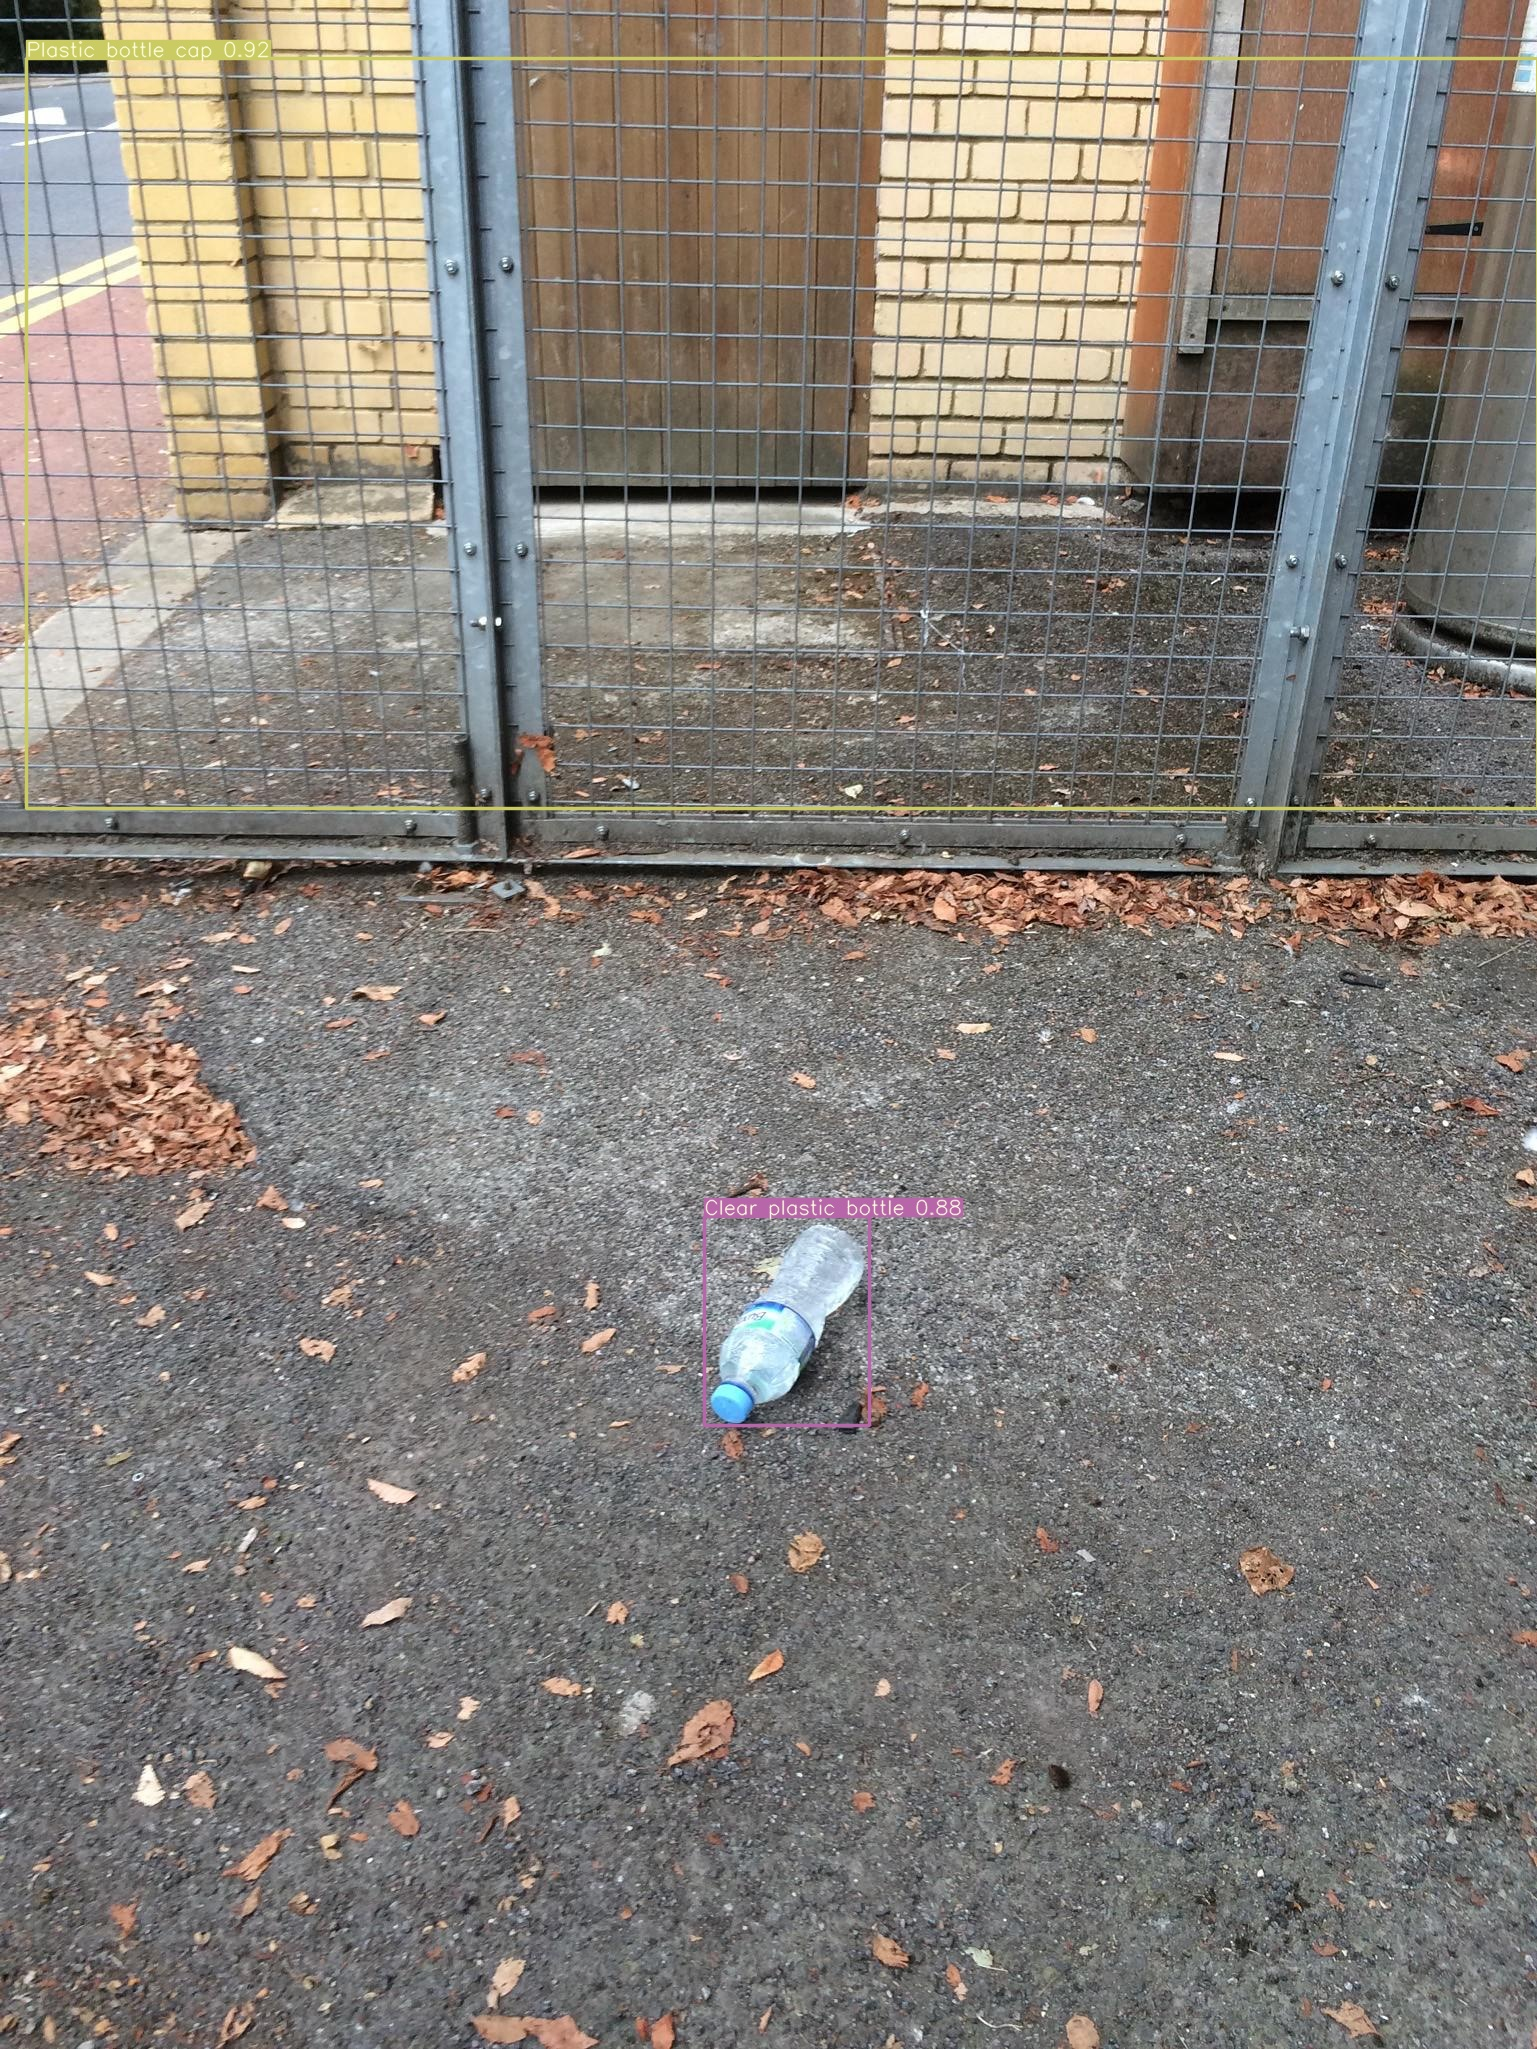

In [ ]:
Image('/content/yolov5/runs/detect/exp3/batch_1_000000.jpg')

In [ ]:
!python detect.py --weights weights/best.pt --img 320 --conf 0.4 --source taco/test/images/batch_5_000017.JPG 

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=320, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='taco/test/images/batch_5_000017.JPG', update=False, view_img=False, weights=['weights/best.pt'])
Using torch 1.7.0+cu101 CUDA:0 (Tesla T4, 15079MB)

Fusing layers... 
Model Summary: 232 layers, 7265397 parameters, 0 gradients
image 1/1 /content/yolov5/taco/test/images/batch_5_000017.JPG: 320x256 1 Clear plastic bottles, 1 Plastic bottle caps, Done. (0.012s)
Results saved to runs/detect/exp4
Done. (0.260s)


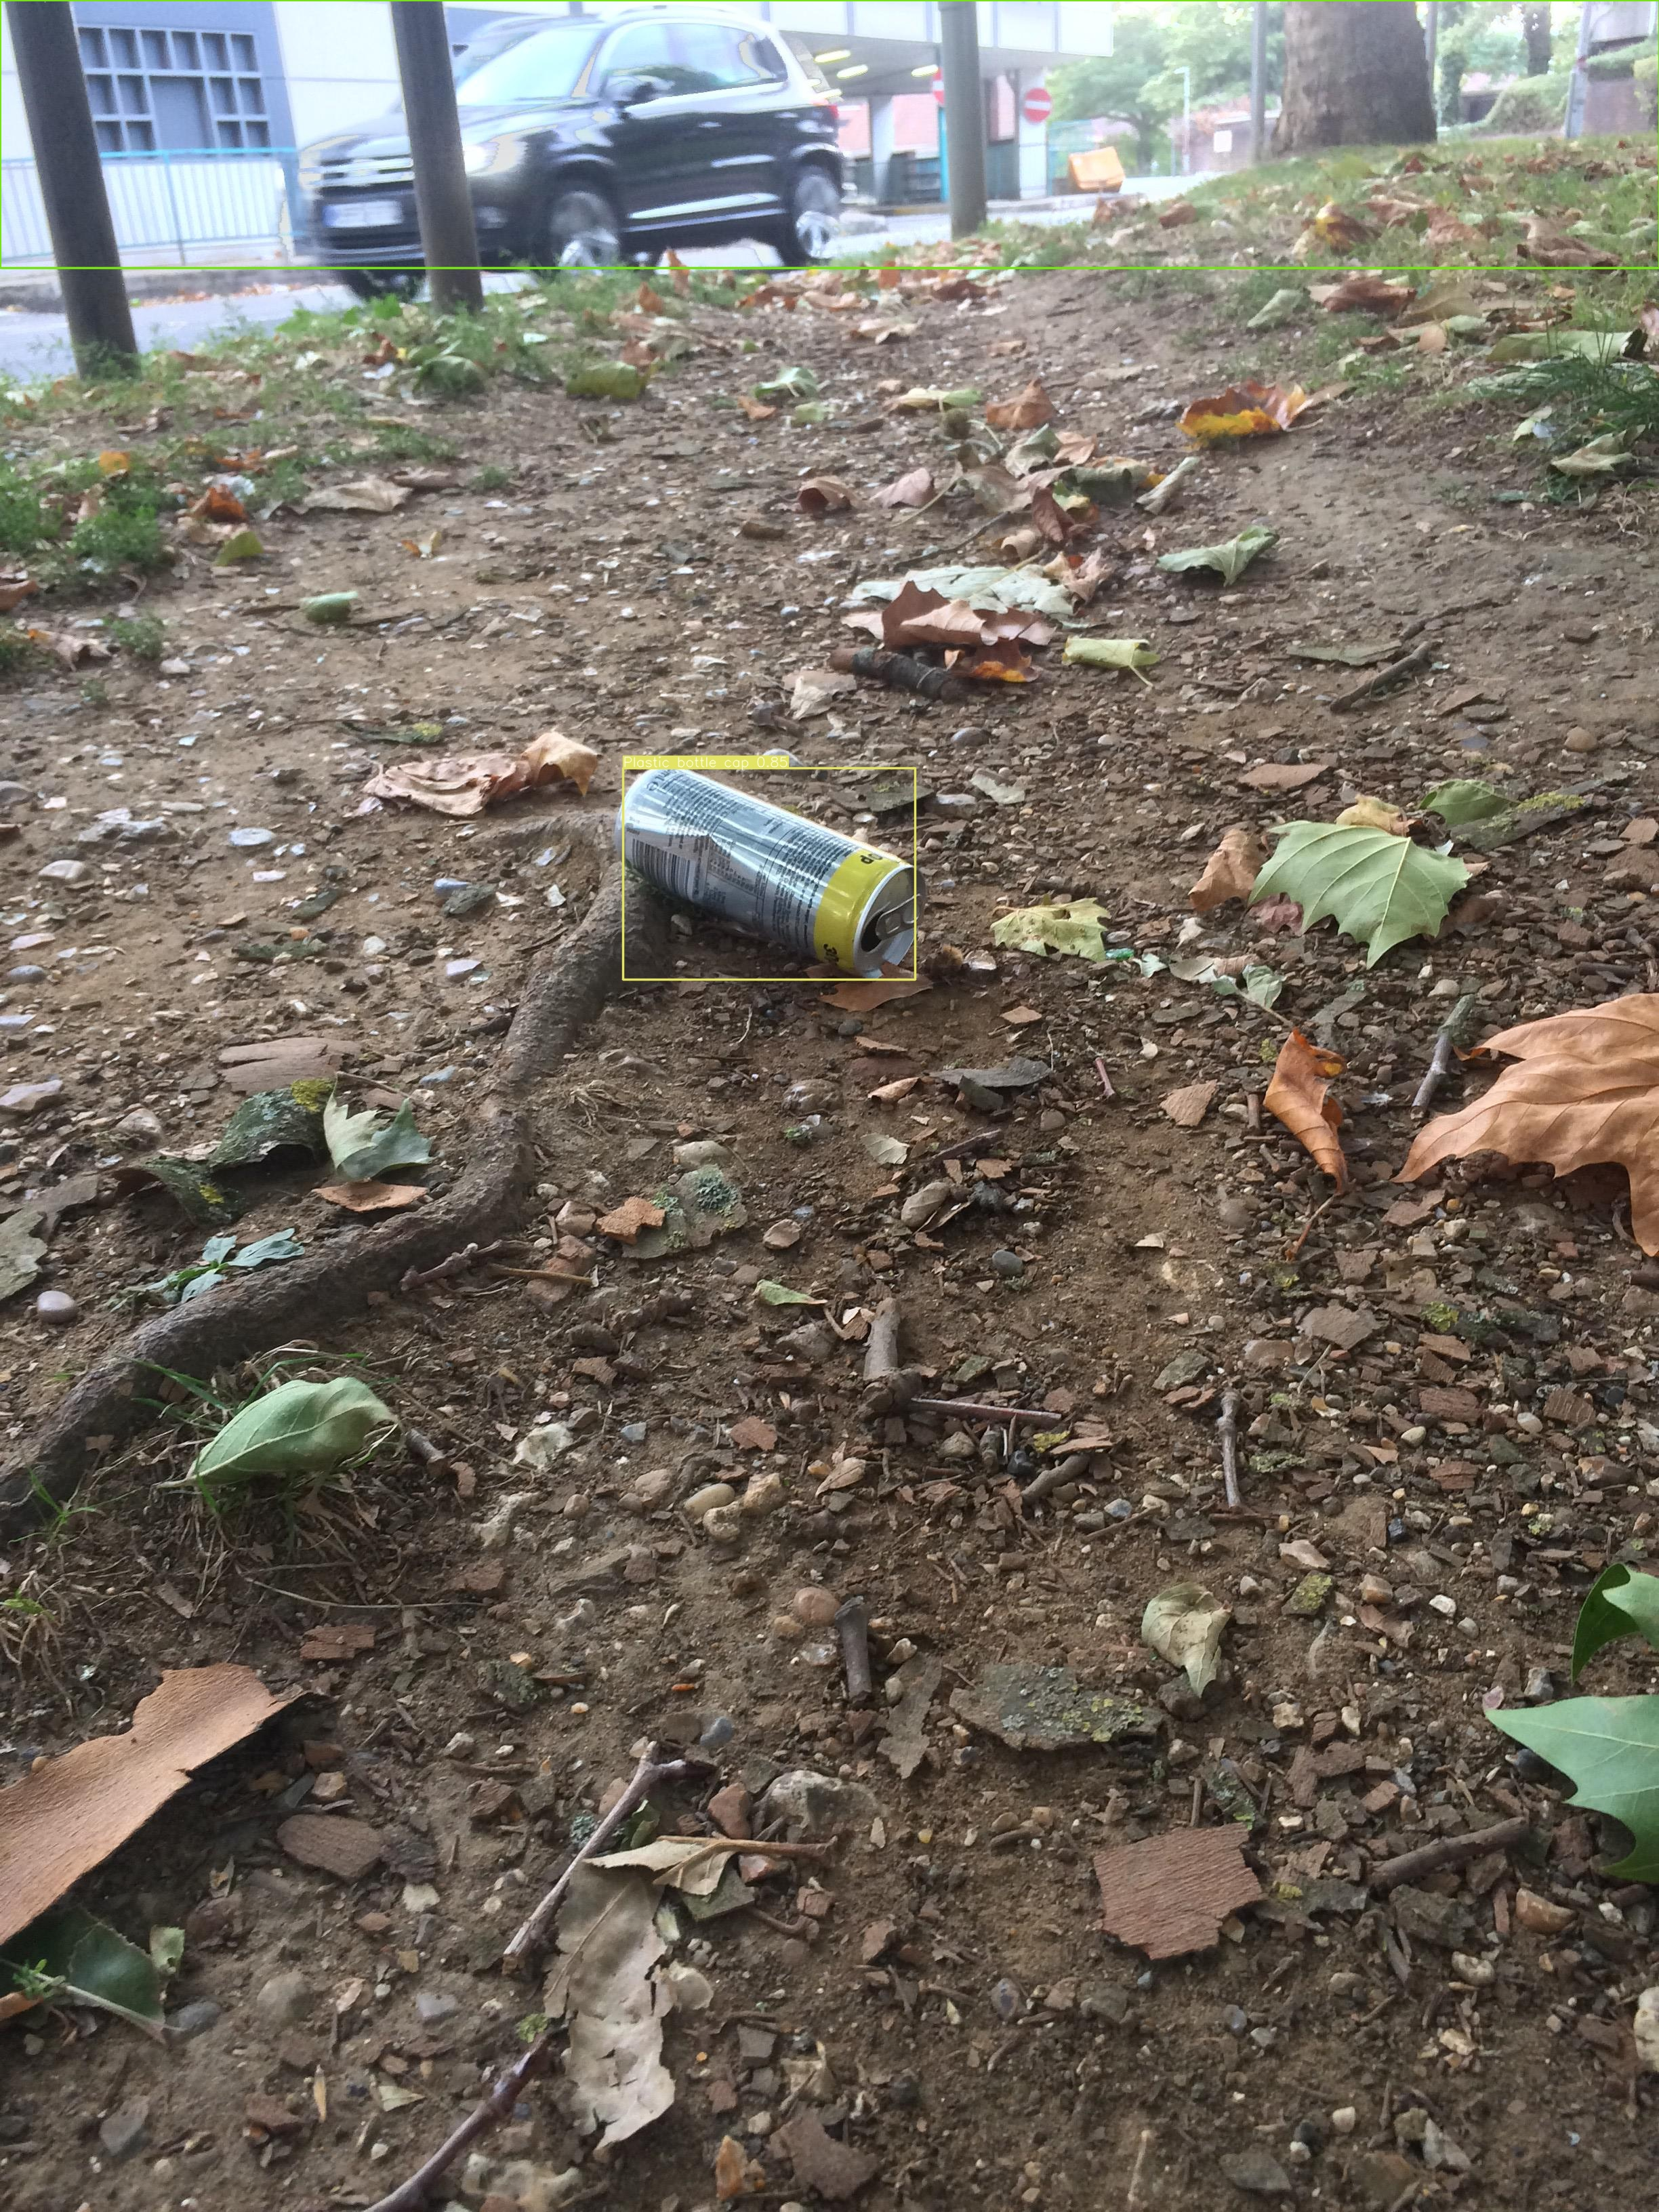

In [ ]:
Image('/content/yolov5/runs/detect/exp4/batch_5_000017.JPG')

In [ ]:
!zip -r trainedweights.zip "/content/yolov5/runs/train"

  adding: content/yolov5/runs/train/ (stored 0%)
  adding: content/yolov5/runs/train/exp2/ (stored 0%)
  adding: content/yolov5/runs/train/exp2/events.out.tfevents.1608387519.0ca403a36988.352.0 (deflated 69%)
  adding: content/yolov5/runs/train/exp2/train_batch1.jpg (deflated 5%)
  adding: content/yolov5/runs/train/exp2/opt.yaml (deflated 50%)
  adding: content/yolov5/runs/train/exp2/labels_correlogram.jpg (deflated 37%)
  adding: content/yolov5/runs/train/exp2/train_batch0.jpg (deflated 2%)
  adding: content/yolov5/runs/train/exp2/train_batch2.jpg (deflated 3%)
  adding: content/yolov5/runs/train/exp2/results.txt (deflated 75%)
  adding: content/yolov5/runs/train/exp2/test_batch1_pred.jpg (deflated 9%)
  adding: content/yolov5/runs/train/exp2/labels.jpg (deflated 18%)
  adding: content/yolov5/runs/train/exp2/test_batch1_labels.jpg (deflated 8%)
  adding: content/yolov5/runs/train/exp2/weights/ (stored 0%)
  adding: content/yolov5/runs/train/exp2/weights/last.pt (deflated 8%)
  adding:

In [ ]:
!pip install onnx>=1.7.0 
!pip install coremltools==4.0 

     |████████████████████████████████| 3.4MB 13.7MB/s 
  Created wheel for attr: filename=attr-0.3.1-cp36-none-any.whl size=2459 sha256=c00572e9dbe44b38b3b934b718f59b8c983291e41b52cd3584a6a4891de90dc5
  Stored in directory: /root/.cache/pip/wheels/f0/96/9b/1f8892a707d17095b5a6eab0275da9d39e68e03a26aee2e726
Successfully built attr


In [ ]:
!python models/export.py --weights "/content/yolov5/runs/train/exp2/weights/best.pt" --img 320 --batch 1

Namespace(batch_size=1, img_size=[320, 320], weights='/content/yolov5/runs/train/exp2/weights/best.pt')
Fusing layers... 
Model Summary: 232 layers, 7265397 parameters, 0 gradients

Starting TorchScript export with torch 1.7.0+cu101...
/usr/local/lib/python3.6/dist-packages/torch/jit/_trace.py:940: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  _force_outplace,
TorchScript export success, saved as /content/yolov5/runs/train/exp2/weights/best.torchscript.pt

Starting ONNX export with onnx 1.8.0...
ONNX export success, saved as /content/yolov5/runs/train/exp2/weights/best.onnx
scikit-learn version 0.22.2.post1 i